In [1]:
#
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.utils import plot_model
from keras import optimizers
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# Configurações

## Flag para limpar dados
CLEAN_DATASET = False

# Flag para decisão de qual versão do dataset usar
DATASET_COMPLETO = False

# Caminho para o dataset
# Endereço para download: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# Backup: http://web.archive.org/web/*/http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
if DATASET_COMPLETO:
    DATASET_PATH = "D:/UNIFEI/TCC/kdd_dl/dataset/kddcup.data.corrected"
    
    # Treino 98%, Validação 1%, Teste 1%
    # https://stackoverflow.com/a/13613316
    TRAIN_PERCENTAGE = 0.98
    VALIDATION_PERCENTAGE = 0.01
    TEST_PERCENTAGE = 0.01
else:
    DATASET_PATH = "D:/UNIFEI/TCC/kdd_dl/dataset/kddcup.data_10_percent_corrected"

    # Treino 80%, Validação 10%, Teste 10%
    TRAIN_PERCENTAGE = 0.8
    VALIDATION_PERCENTAGE = 0.1
    TEST_PERCENTAGE = 0.1
    
## Threshold de correlação para exclusão do dataset
CORRCOEF_THRESHOLD = 0.5

## Ignora os warnings de divisão por NaN
np.seterr(divide='ignore', invalid='ignore')

BATCH_SIZE = 1024 #
EPOCHS = 10 #
SHUFFLE = True #
VERBOSE = 1 #
VALIDATION_SPLIT=0.2 #

In [3]:
# Nome das colunas do dataset
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack",
]

#Leitura do dataset
dataset = pd.read_csv(
    DATASET_PATH,
    header = None,
    names = column_names)

In [4]:
#Pega os valores  únicos das colunas que tem string
protocol_type_values = dataset.protocol_type.unique()
protocol_type_dict = dict(zip(protocol_type_values, range(len(protocol_type_values))))

service_values = dataset.service.unique()
service_dict = dict(zip(service_values, range(len(service_values))))

flag_values = dataset.flag.unique()
flag_dict = dict(zip(flag_values, range(len(flag_values))))

attack_values = dataset.attack.unique()
attack_dict = dict(zip(attack_values, range(len(attack_values))))

#TODO: Dá para trocar o protocol_type, service, flag e attack por uma função de filtro ao invés de preencher tudo na mão
# protocol_type = {"icmp": 0, "tcp": 1, "udp": 2}
# service = {"auth": 0, "bgp": 1, "courier": 2, "csnet_ns": 3, "ctf": 4, "daytime": 5, "discard": 6, "domain": 7, "domain_u": 8, "echo": 9, "eco_i": 10, "ecr_i": 11, "efs": 12, "exec": 13, "finger": 14, "ftp": 15, "ftp_data": 16, "gopher": 17, "hostnames": 18, "http": 19, "http_443": 20, "imap4": 21, "IRC": 22, "iso_tsap": 23, "klogin": 24, "kshell": 25, "ldap": 26, "link": 27, "login": 28, "mtp": 29, "name": 30, "netbios_dgm": 31, "netbios_ns": 32, "netbios_ssn": 33, "netstat": 34, "nnsp": 35, "nntp": 36, "ntp_u": 37, "other": 38, "pm_dump": 39, "pop_2": 40, "pop_3": 41, "printer": 42, "private": 43, "red_i": 44, "remote_job": 45, "rje": 46, "shell": 47, "smtp": 48, "sql_net": 49, "ssh": 50, "sunrpc": 51, "supdup": 52, "systat": 53, "telnet": 54, "tftp_u": 55, "time": 56, "tim_i": 57, "urh_i": 58, "urp_i": 59, "uucp": 60, "uucp_path": 61, "vmnet": 62, "whois": 63, "X11": 64, "Z39_50": 65, "http_2784": 66, "http_443": 67, "http_8001": 68, "aol": 69, "harvest": 70,}
# flag = {"OTH": 0,"REJ": 1,"RSTO": 2,"RSTOS0": 3,"RSTR": 4,"S0": 5,"S1": 6,"S2": 7,"S3": 8,"SF": 9,"SH": 10}
# attack = {"back.": 0,"buffer_overflow.": 1,"ftp_write.": 2,"guess_passwd.": 3,"imap.": 4,"ipsweep.": 5,"land.": 6,"loadmodule.": 7,"multihop.": 8,"neptune.": 9,"nmap.": 10,"normal.": 11,"perl.": 12,"phf.": 13,"pod.": 14,"portsweep.": 15,"rootkit.": 16,"satan.": 17,"smurf.": 18,"spy.": 19,"teardrop.": 20,"warezclient.": 21,"warezmaster.": 22}

In [5]:
#Substitui os valores por int
dataset = dataset.replace(
    {"protocol_type": protocol_type_dict,
     "service": service_dict,
     "flag": flag_dict,
     "attack": attack_dict}
)

dataset = dataset.apply(pd.to_numeric)

In [6]:
if CLEAN_DATASET:
    excluded = list()
    
    for index_1 in range(len(column_names)-1):
        for index_2 in range(len(column_names)-1):
            if column_names[index_1] not in excluded and column_names[index_2] not in excluded and index_1 != index_2:
                corrcoef = np.corrcoef(dataset[column_names[index_1]], dataset[column_names[index_2]])

                if abs(corrcoef[0][1]) > CORRCOEF_THRESHOLD:
                    excluded.append(column_names[index_2])
                
    dataset = dataset[dataset.columns.difference(excluded)]

In [7]:
train, test = np.split(dataset.sample(frac=1), [int(TRAIN_PERCENTAGE * len(dataset))])

train_samples = train.drop(['attack'], axis=1)
train_labels = to_categorical(train[['attack']].to_numpy())

test_samples = test.drop(['attack'], axis=1)
test_labels = to_categorical(test[['attack']].to_numpy())

In [8]:
input_shape = (train_samples.shape[1],)

# Criação do modelo
model = Sequential([
    Dense(16, input_shape=input_shape, activation='relu'), #TODO: Mudar número do shape pra ficar automágico
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(attack_values), activation='softmax'),
])

# model = Sequential([
#     Dense(16, input_shape=(22,), activation='relu'), #TODO: Mudar número do shape pra ficar automágico
#     Dense(32, activation='relu'),
#     Dense(23, activation='softmax'),
# ])

In [9]:
# sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
sgd = optimizers.SGD(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=sgd)

model.compile(
    optimizer=sgd,
    loss='mean_squared_error', 
    metrics=['accuracy'],
)

In [10]:
# Treinamento do modelo
history = model.fit(
    x=train_samples, 
    y=train_labels, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    shuffle=SHUFFLE, #Mistura os dados
    verbose=VERBOSE,
    validation_split=VALIDATION_SPLIT #Porcentagem dos dados de treino que serão usadas para validação
)

Train on 316172 samples, validate on 79044 samples
Epoch 1/10
316172/316172 [==============================] - 2s 5us/step - loss: 0.0299 - accuracy: 0.5538 - val_loss: 0.0276 - val_accuracy: 0.5662
Epoch 2/10
316172/316172 [==============================] - 1s 4us/step - loss: 0.0272 - accuracy: 0.5690 - val_loss: 0.0270 - val_accuracy: 0.5661
Epoch 3/10
316172/316172 [==============================] - 1s 4us/step - loss: 0.0270 - accuracy: 0.5690 - val_loss: 0.0269 - val_accuracy: 0.5661
Epoch 4/10
316172/316172 [==============================] - 1s 4us/step - loss: 0.0270 - accuracy: 0.5690 - val_loss: 0.0273 - val_accuracy: 0.5662
Epoch 5/10
316172/316172 [==============================] - 1s 4us/step - loss: 0.0268 - accuracy: 0.5690 - val_loss: 0.0264 - val_accuracy: 0.5661
Epoch 6/10
316172/316172 [==============================] - 1s 4us/step - loss: 0.0265 - accuracy: 0.5690 - val_loss: 0.0271 - val_accuracy: 0.5661
Epoch 7/10
316172/316172 [==============================] - 1

98805/98805 [==============================] - 3s 34us/step


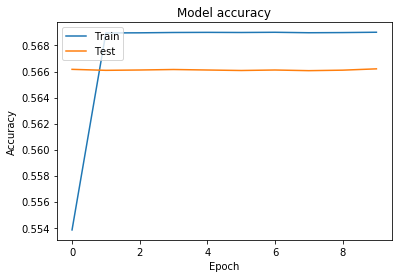

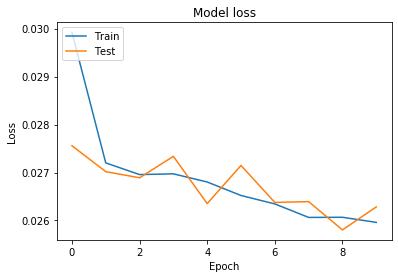

['loss', 'accuracy']
[0.026137104232962706, 0.5677748918533325]


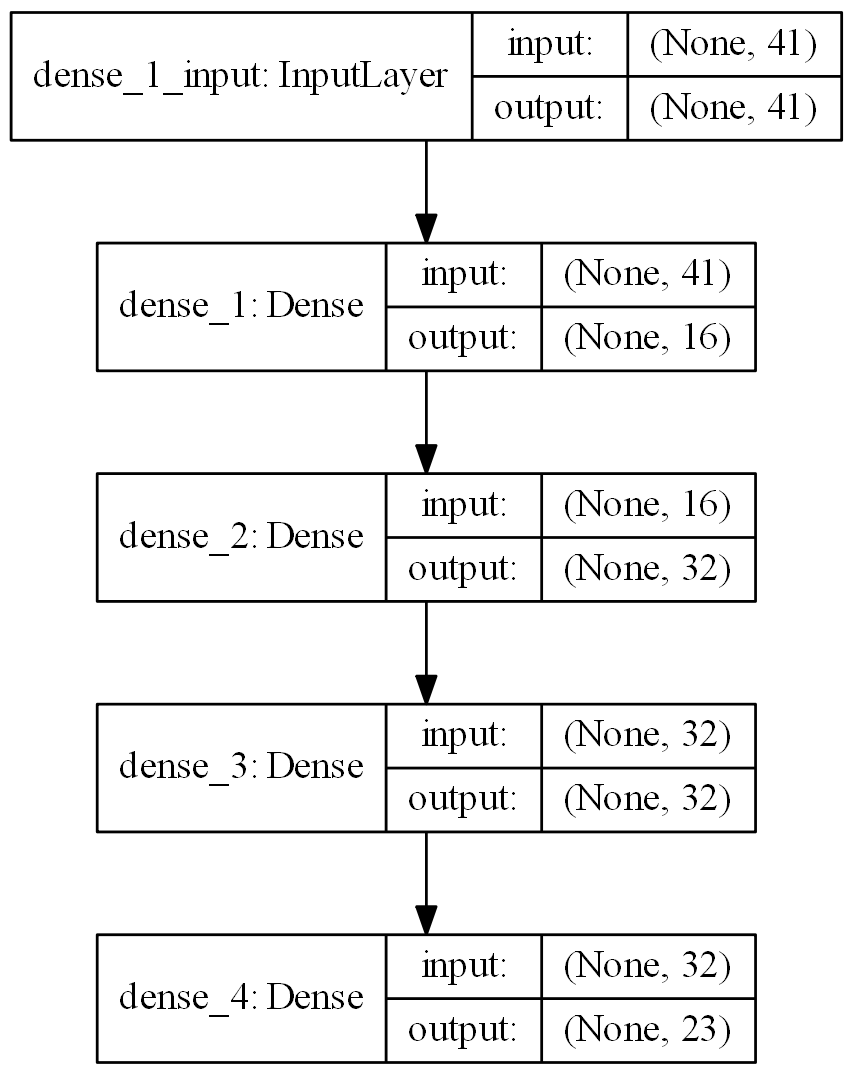

In [11]:
# Teste do modelo
h2 = model.evaluate(
    x=test_samples,
    y=test_labels,
    verbose=VERBOSE,
)

plot_model(model, to_file='model.png')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print(model.metrics_names)
print(h2)

plot_model(model, to_file='model.png' ,show_shapes=True, show_layer_names=True, expand_nested=True, dpi=200)

In [12]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
# from keras import backend as K

# with a Sequential model
# get_3rd_layer_output = K.function([model.layers[0].input],
#                                   [model.layers[3].output])
# print(get_3rd_layer_output)

# print(model.layers[0].input)
# print(model.layers[0].output)

# print(model.layers[1].input)
# print(model.layers[1].output)

# print(model.layers[2].input)
# print(model.layers[2].output)

# print(model.layers[3].input)
# print(model.layers[3].output)

# from keras import backend as K

input1 = model.input # input placeholder

output1 = [layer.output for layer in model.layers]# all layer outputs

fun = K.function([input1, K.learning_phase()],output1)# evaluation function

# Testing

t = np.random.random((41,))[np.newaxis,...]

t = np.array([[0,1,19,9,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00]])

layer_outputs = fun([t, 1])



print(layer_outputs[0]) #printing the outputs of layers
print(layer_outputs[1]) #printing the outputs of layers
print(layer_outputs[2]) #printing the outputs of layers
print(layer_outputs[3]) #printing the outputs of layers

[[1136.322 614.553 1236.075 1408.359 0.000 0.000 454.334 0.000 0.000
  1174.451 1519.675 0.000 606.919 0.000 0.000 1017.830]]
[[671.057 228.600 0.000 0.000 967.557 1491.323 0.000 0.000 50.598 520.766
  96.225 621.940 0.000 639.261 232.958 0.000 908.051 866.348 0.000
  234.093 147.652 283.782 106.378 0.000 0.000 60.440 1350.509 312.924
  0.000 0.000 0.000 0.000]]
[[858.517 0.000 163.150 784.791 0.000 0.000 400.938 0.000 0.000 805.749
  0.000 0.000 0.000 138.767 608.699 262.572 0.000 0.000 33.722 0.000
  0.000 315.402 0.000 0.000 377.287 576.814 381.019 0.000 0.000 673.328
  0.000 0.000]]
[[0.000 0.000 0.000 0.024 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
  0.000 0.000 0.000 0.000 0.000 0.000 0.976 0.000 0.000 0.000 0.000]]
